In [1]:
# Место для welcome картинки

Содержание:

* [Введение](#Введение)
* [Практическая часть](#Практика)
* [Пара слов о шуме](##Пара)
* [Теперь точно практика](##Теперь)
* [Пробуем начать с нуля](#Пробуем)
* [Небольшое погружение](#Небольшое)


Ссылки:

* [Та самая статья](https://arxiv.org/abs/2006.11239)
* [Курс от huggingface](https://github.com/huggingface/diffusion-models-class)
* [Рассуждения в блоге](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
* [Классный курс лекиций](https://scholar.harvard.edu/binxuw/classes/machine-learning-scratch/materials/stable-diffusion-scratch)


#Введение


Мы уже познакомились с некоторыми генеративными моделями. В каждом из семейств моделей (не обязательно служащих для генерации) присутствует своя генеральная идея, концепция, на которой впоследствие строятся гипотезы. Попробуем начать объяснение работы диффузных моделей сразу с такой идеи.

Итак - а что если сделать процесс генерации итеративным?

Получаем примерную схему

*   Шаг 1: Ничего
*   ???
*   Шаг n: Что-то осмысленное

*it ain't much but it's honest work . jpg*

Что такое *Ничего*?
Довольно часто под *ничем* воспринимают простой чёрный (или белый) фон, однако, если подумать, то оба эти состояния характеризуются довольно высокой упорядоченностью.
Для нашего повествования за стартовую точку будет взят случайный шум

Что такое *что-то осмысленное*?
Единственный сразу понятный пункт - по старой традиции, сложившейся в процессе курса, осмыслять будем числа из датасета mnist 👀

Дело за малым, понять, что будет в *???*

Сегодня мы поговорим о том, какие ответы на этот вопрос придумало сообщество. Большинство из этих ответов можно найти в статье, посвященной диффузным моделям, а также в курсе от hugging face и в блоке лекций по диффузным моделям. Именно на этих материалах был наибольший фокус при подготовке данного ноутбука.

Перейдём к интересному. На данный момент консенсус в следующем: в оставшихся n-2 шагах содержится то, что мы хотим получить в шаге n, но в испорченном виде.



> А так как лейтмотивом наших встреч являются нейронные сети, то дальнейший разговор пойдёт о том, как с их помощью перейти от шага 1 к шагу n



#Практика

In [2]:
!pip install -U diffusers;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.4 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
from diffusers import DDPMScheduler, UNet2DModel

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [5]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 47002316.72it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107867937.51it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28771737.84it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22897270.15it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
train_dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

Input shape: torch.Size([6, 1, 28, 28])
Labels: tensor([0, 2, 9, 3, 3, 6])


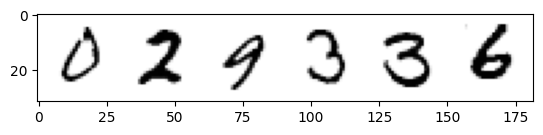

In [7]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

##Пара слов о шуме

Нам нужно найти способ, при помощи которого мы бы смогли получать (в нашем случае) испорченное изображение, на котором можно было бы обучиться переходу между состояниями

В статье, которая была упомянута выше, (далее будем называть её DDPM) описан некоторый процесс порчи данных, который по факту определен для любого из наших состояний. Суть процесса заключается в том, что из любого состояния  $x_{t-1}$ мы можем перейти в следующеее чуть более зашумленное $x_t$ при помощи формулы:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


Мы берем вход $x_{t-1}$, а точнее $\sqrt{1 - \beta_t}$ часть входа и добавляем к ней шум, помноженный на $\beta_t$.  $\beta$ определена для каждого t и показывает, насколько сильно будет испорчено изображение. Также благодаря такой конструкции, мы можем напрямую перейти от $x_0$ к любому состоянию $x_t$ игнорируя все промежуточные ступени: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ где $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ и $\alpha_i = 1-\beta_i$<br><br>

То есть переход в любое состояние происходит при помощи перемножения коэффициентов

Мы можем посмотреть за тем, как меняется количество сигнала и количество шума в изображении в зависимости от номера шага

**Но можно чуть проще.** В одномерном случае мы можем представить себе процесс диффузии вот так ([если очень интересно копнуть глубже](https://yang-song.net/blog/2021/score/#reversing-the-sde-for-sample-generation))
\begin{equation}
\begin{split}
x(t + \Delta t) = x(t) + \sigma(t) \sqrt{\Delta t} \ r
\end{split}
\end{equation}
где $\sigma(t) > 0$ сила шума, $\Delta t$ размер шага и $r \sim \mathcal{N}(0, 1)$ нормально распределенная случайная величина. По сути, как и было раньше, мы последовательно добавляем всё больше и больше нормального шума к нашей изначальной величине Обычно $\sigma(t)$ зависит от времени.

In [8]:
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: начальное значение
  noise_strength_fn: функция от времени
  t0: начало отсчёта времени
  nsteps: количество шагов диффузии
  dt: длина шага по времени
  """

  # Задаем траекторию
  x = np.zeros(nsteps + 1)
  x[0] = x0
  t = t0 + np.arange(nsteps + 1) * dt

  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i])
    random_normal = np.random.randn()
    x[i+1] = x[i] + random_normal * noise_strength
  return x, t


# Пример функции силы шума (чаще всего есть зависимость от времени, но воспользуемся константой)
def noise_strength_constant(t):
  return 1

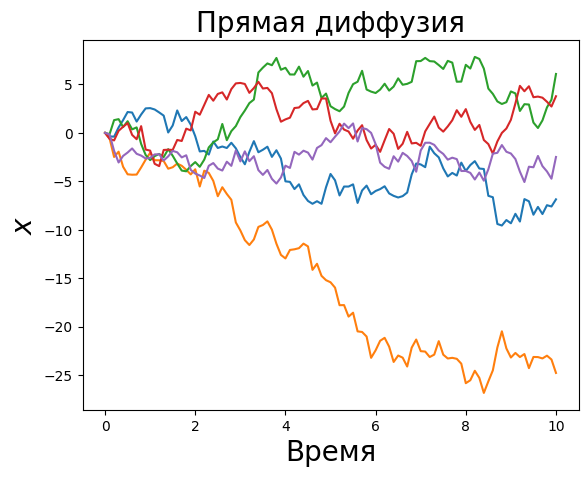

In [9]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
  x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

  plt.plot(t, x)
  plt.xlabel('Время', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Прямая диффузия', fontsize=20)
plt.show()

Мыжем попытаться обратить этот процесс при помощи принципа, схожего с тем, как мы пришли в нашу точку (ну или точки)
\begin{equation}
x(t + \Delta t) = x(t) + \sigma(T - t)^2 \frac{d}{dx}\left[ \log p(x, T-t) \right] \Delta t + \sigma(T-t) \sqrt{\Delta t} \ r
\end{equation}
где
\begin{equation}
s(x, t) := \frac{d}{dx} \log p(x, t)
\end{equation}
так называемая **score function**. Если мы знаем вид этой функции, то мы можем обратить процесс диффузии.

В нашем примере мы всегда стартовали из нуля $x_0 = 0$, сила шума также постоянна, отсюда получаем уравнение
\begin{equation}
s(x, t) = - \frac{(x - x_0)}{\sigma^2 t} = - \frac{x}{\sigma^2 t} \ .
\end{equation}

In [11]:
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
  """
  score_fn: score function
  T: конечная отсечка по времени в прямом процессе
  nsteps: число шагов
  dt: размер шага
  """
  x = np.zeros(nsteps + 1)
  x[0] = x0
  t = np.arange(nsteps + 1) * dt

  for i in range(nsteps):
    noise_strength = noise_strength_fn(T - t[i])
    score = score_fn(x[i], 0, noise_strength, T-t[i])
    random_normal = np.random.randn()
    x[i+1] = x[i] + (score * (noise_strength ** 2) * dt) + (noise_strength * random_normal * np.sqrt(dt))
  return x, t


# Example noise strength function: always equal to 1
def score_simple(x, x0, noise_strength, t):
  score = - (x - x0) / ((noise_strength ** 2) * t)
  return score

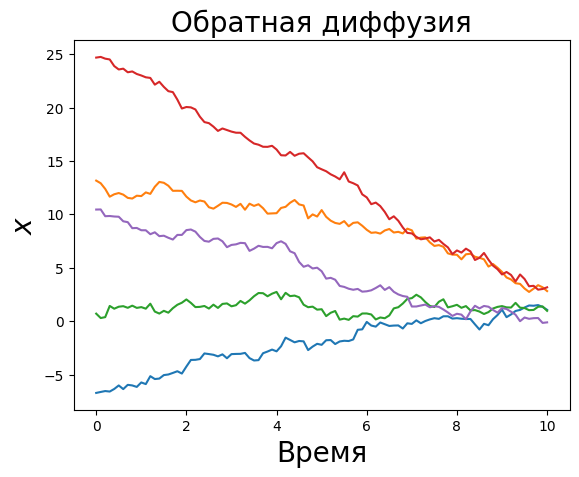

In [12]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
score_fn = score_simple
x0 = 0
T = 11


num_tries = 5
for i in range(num_tries):
  x0 = np.random.normal(loc=0, scale=T)
  x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

  plt.plot(t, x)
  plt.xlabel('Время', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Обратная диффузия', fontsize=20)
plt.show()

На практике мы обычно не знаем score function, вместо этого применяется стандартный подход - вид этой функции можно "выучить". Сделать это можно при помощи нейросети со специальной целевой функцией
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0)}\left[ \ \Vert s(x_{noised}, t) \sigma^2(t) + (x_{noised} - x_0)  \Vert^2_2  \ \right]
\end{equation}
где $p_0(x_0)$ наше целевое распределение (например, цифры из мниста), и где $x_{noised}$ это объект из целевого распределения $x_0$ после одного прямого шага диффузии, то есть $x_{noised} - x_0$ просто НРСВ.

Есть другой способ переписать это уравнение:
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert s(x_0 + \sigma(t) \epsilon, t) \sigma(t) + \epsilon  \Vert^2_2  \ \right]
\end{equation}
За этим стоит следующая интуиция: мы учимся предсказывать **как много шума было добавлено к каждой части нашего объекта**. Мы молжны уметь это делать достаточно хорошо в каждый момент времени $t$ для каждого $x_0$ из нашего изначального распределения.

## Теперь точно практика

Как же нам подойти к проблеме, что обозначена выше?

Основная суть повествования выше - если мы выучим score function, то сможем перейти от чистого шума к чему-то более осмысленному. Приблизить некоторую функцию нейронной сетью - типичная задача в машинном обучении. Нужно учесть, что сейчас, в отличие от примеров выше, мы начинаем работать с изображениями, нам следует выбрать подход, который смог бы наилучшим образом учесть все особенности, связанные с этим типом данных.

Типичной практикой для CV является использование свёрточных сетей ввиду того что это:
* естественный способ задания функции над изображением
* отличный способ выделения паттернов в изображениях вне зависимости от того, где последние на нём находятся (feature translational invariance)

В частности из-за этого свёртки хороши в задачах классификации и распознавания

На основе свёрток построена далеко не одна архитектура, для нашей задачей хорошим выбором будет [U-Net](https://en.wikipedia.org/wiki/U-Net), которая объединяет в себе CNN-like структуры с downscaling/upscaling операциями, которые и помогают сети обнаруживать особенности на разных уровнях масштаба внутри изображений.



In [13]:
def corrupt(x, amount):
  """Задаём способ порчи данных"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x * (1 - amount) + noise * amount

In [14]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # активация
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2: # Для всех, кроме последнего слоя:
              h.append(x) # Сохраняем выход для skip connection
              x = self.downscale(x) # Downscale для следующего слоя

        for i, l in enumerate(self.up_layers):
            if i > 0: # Для всех слоёв, кроме первого
              x = self.upscale(x) # Upscale
              x += h.pop() # Skip connection
            x = self.act(l(x))

        return x

In [15]:
net = BasicUNet()
x = torch.rand(6, 1, 28, 28)
net(x).shape

torch.Size([6, 1, 28, 28])

In [16]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.025666
Finished epoch 1. Average loss for this epoch: 0.019808
Finished epoch 2. Average loss for this epoch: 0.018274
Finished epoch 3. Average loss for this epoch: 0.017534
Finished epoch 4. Average loss for this epoch: 0.016860
Finished epoch 5. Average loss for this epoch: 0.016635
Finished epoch 6. Average loss for this epoch: 0.016462
Finished epoch 7. Average loss for this epoch: 0.016127
Finished epoch 8. Average loss for this epoch: 0.016045
Finished epoch 9. Average loss for this epoch: 0.015806


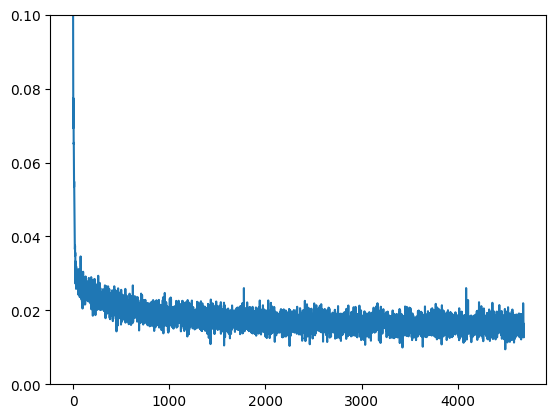

In [17]:
# Даталоадер
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Сколько раз будем проходиться по выборке
n_epochs = 10

# Объявляем архитектуру
net = BasicUNet()
net.to(device)

# Функция потерь
loss_fn = nn.MSELoss()

# Оптимизатор
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Будем отслеживать прогресс
losses = []

# Цикл обучения
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Получаем данные и пытаемся их испортить
        x = x.to(device) # Помещаем данные на видеокарту
        noise_amount = torch.rand(x.shape[0]).to(device) # Количество шума
        noisy_x = corrupt(x, noise_amount) # Портим наш X

        # Получаем предсказание
        pred = net(noisy_x)

        # Вычисляем функцию потерь
        loss = loss_fn(pred, x) # Насколько наши данные близки к первоначальному X?

        # Алгоритм обратного распространения ошибки и обновление коэфициентов
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Записываем значение функции потерь
        losses.append(loss.item())

    # Выводим среднее значение функции потерь
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Выводим график
plt.plot(losses)
plt.ylim(0, 0.1);

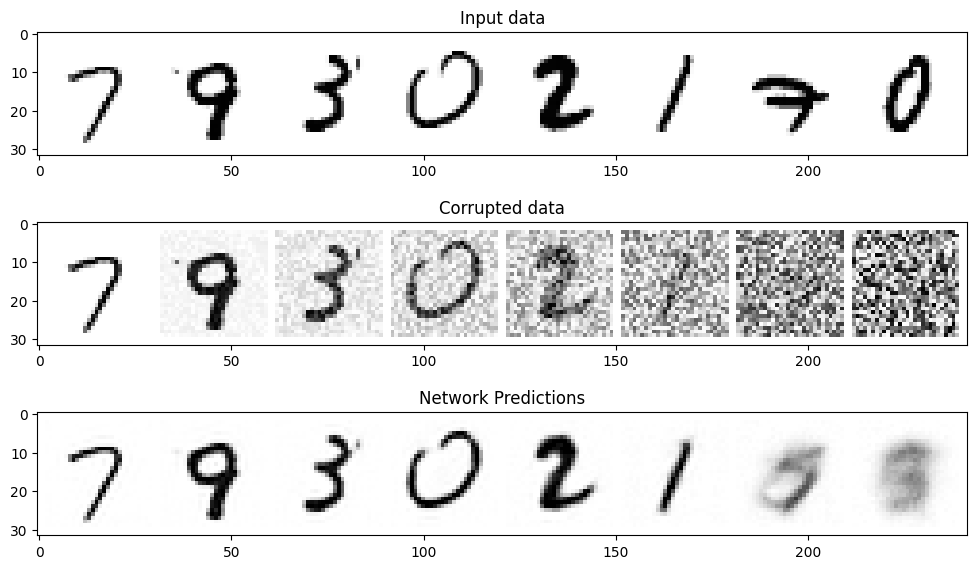

In [ ]:
#Выводим предсказания по зашумленным данным

x, y = next(iter(train_dataloader))
x = x[:8] # Берем первые 8 для простоты визуализации

# Зашумляем данные
amount = torch.linspace(0, 1, x.shape[0]) # Слева направо -> уровень шума растет
noised_x = corrupt(x, amount)

# Получаем предсказания
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

#Попробуем начать с нуля

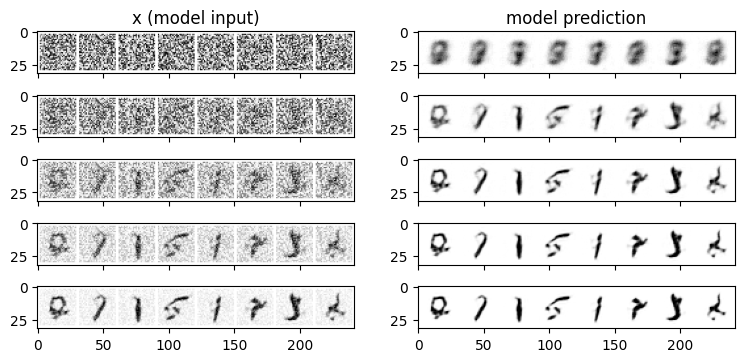

In [18]:
#Разбиваем процесс на 5 шагов и продвигаемся на 1/5 к цели за раз:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Начинаем со случайного шума
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # Убираем градиенты на время использования модели
        pred = net(x) # Пробуем сделать предсказание
    pred_output_history.append(pred.detach().cpu()) # Сохраняем промежуточный результат для визуализации
    mix_factor = 1/(n_steps - i) # Как быстро мы приближаемся к цели
    x = x*(1-mix_factor) + pred*mix_factor # Делаем шаг
    step_history.append(x.detach().cpu()) # Сохраняем результат для визуализации

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

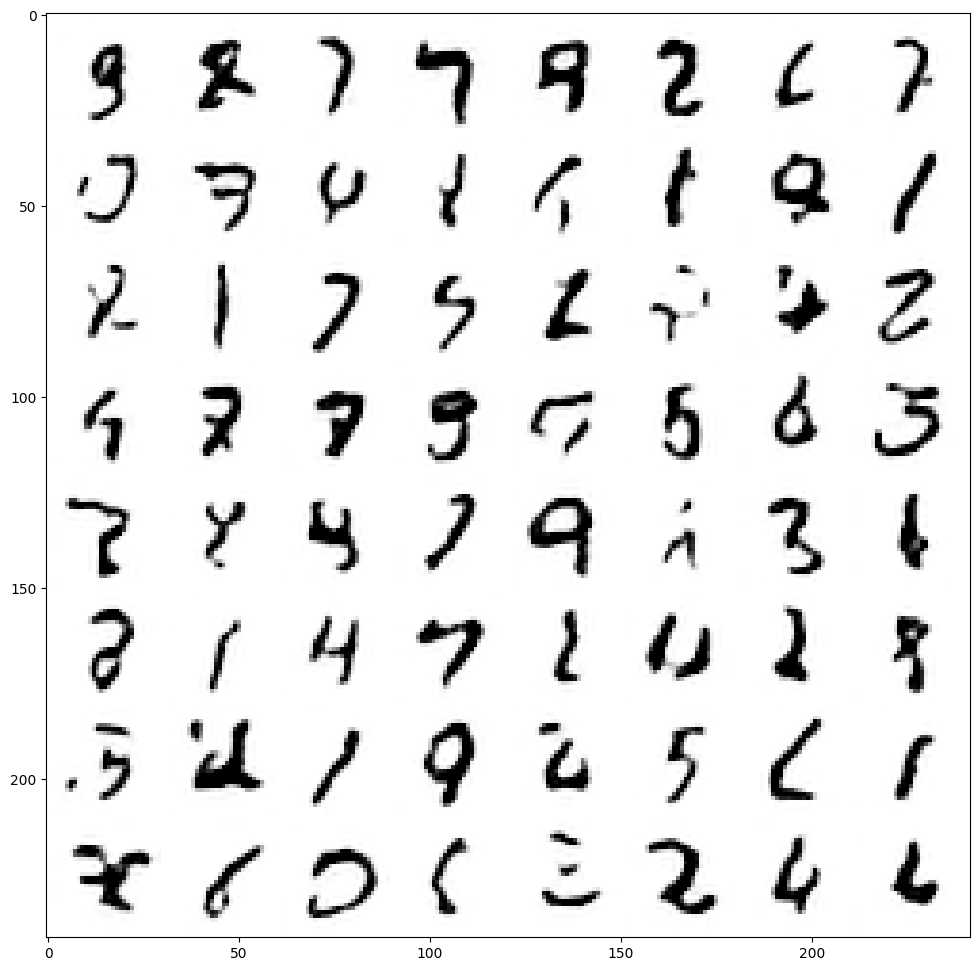

In [19]:
# Что если сделать больше шагов?
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Постепенно уменьшаем уровень шума
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

#Небольшое погружение

In [ ]:
# Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

Finished epoch 0. Average loss for this epoch: 0.019142
Finished epoch 1. Average loss for this epoch: 0.012698
Finished epoch 2. Average loss for this epoch: 0.011677
Finished epoch 3. Average loss for this epoch: 0.011052
Finished epoch 4. Average loss for this epoch: 0.010795
Finished epoch 5. Average loss for this epoch: 0.010506
Finished epoch 6. Average loss for this epoch: 0.010438
Finished epoch 7. Average loss for this epoch: 0.010013


In [ ]:
sum([p.numel() for p in net.parameters()])